In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Piedecuesta_Lags.csv', encoding='latin-1', sep=";")


# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_6',
                    'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_5',
                    'Total_Preci_Sem', 'Total_Preci_Sem_6', 'Total_Preci_Sem_1',
                    'Total_Preci_Sem_2', 'Total_Preci_Sem_3', 'Total_Preci_Sem_5'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_4', 'Total_Preci_Sem_4'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_4     6
Total_Preci_Sem_4    6
dtype: int64

In [4]:
from sklearn.impute import KNNImputer
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
knnImputer.fit(datos[['Prom_Dia_Preci_4']])
datos['Prom_Dia_Preci_4'] = knnImputer.transform(datos[['Prom_Dia_Preci_4']]).ravel()
knnImputer.fit(datos[['Total_Preci_Sem_4']])
datos['Total_Preci_Sem_4'] = knnImputer.transform(datos[['Total_Preci_Sem_4']]).ravel()

#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_4     0
Total_Preci_Sem_4    0
dtype: int64

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

473 203


In [6]:
f_columns = ['Prom_Dia_Preci_4', 'Total_Preci_Sem_4']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


In [10]:
Piede_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Piede_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Piede_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Piede_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Piede_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_MLP_model_4.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Piede_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Piede_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
15/15 - 4s - loss: 0.0439 - val_loss: 0.0105 - 4s/epoch - 245ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0163 - val_loss: 0.0098 - 200ms/epoch - 13ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0136 - val_loss: 0.0171 - 155ms/epoch - 10ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0344 - val_loss: 0.0273 - 129ms/epoch - 9ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0285 - val_loss: 0.0221 - 109ms/epoch - 7ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0268 - val_loss: 0.0121 - 99ms/epoch - 7ms/step


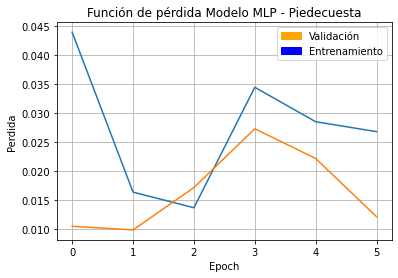

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Piede_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

7/7 [==============================] - 0s 3ms/step
(1, 466)
(1, 196)
(1, 196)


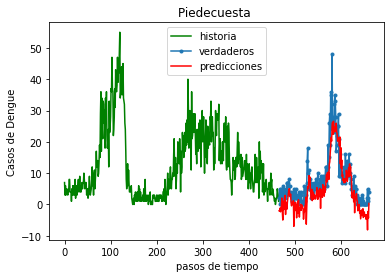

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Piedecuesta ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

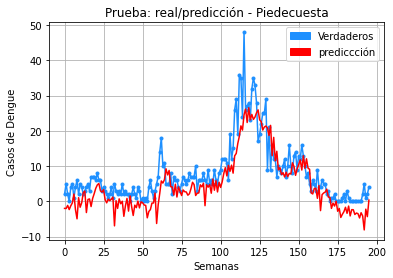

In [14]:
plt.title('Prueba: real/predicción - Piedecuesta' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Piedecuesta       : {}".format(score))
print("MSE Piedecuesta  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Piedecuesta= ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Piedecuesta  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Piedecuesta  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Piedecuesta       : 5.452895509163408
MSE Piedecuesta  =  29.734069433854465
MAE Piedecuesta=  4.140272810119109
r2_score Piedecuesta  =  0.572683019658041
explained_variance_score Piedecuesta  =  0.7196801726285338


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,2.0,-2.016419,-4.016419
1,5.0,-2.049595,-7.049595
2,2.0,-1.171580,-3.171580
3,0.0,-2.350955,-2.350955
4,4.0,-1.266577,-5.266577
5,5.0,-0.463838,-5.463838
6,1.0,2.068050,1.068050
7,4.0,-2.379995,-6.379995
8,6.0,-4.976768,-10.976768
9,2.0,1.034024,-0.965976


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
136,7.0,14.202060,7.202060
137,10.0,8.931810,-1.068190
138,9.0,9.548374,0.548374
139,8.0,7.596600,-0.403400
140,10.0,8.109340,-1.890660
141,12.0,6.928987,-5.071013
142,7.0,8.258196,1.258196
143,10.0,7.015126,-2.984874
144,16.0,7.913002,-8.086998
145,10.0,7.764657,-2.235343
